In [ ]:
import numpy as np
iset=4
flsv = rf'U:\MERFISHp\12_04_2025_JenieSample\final_spots\finalspots_s{iset}.npz'
dic = np.load(flsv)
Xs=dic['Xs']
genes=dic['genes']
pos=dic['pos']
ifovs=dic['ifovs']
pos_fovs=dic['pos_fovs']

In [ ]:
dic_pair={}
dfov = 288.1
from scipy.spatial import KDTree
tree = KDTree(pos_fovs)
neighs = tree.query_ball_point(pos_fovs,dfov*1.1)

In [ ]:
from tqdm import tqdm
for ifov in tqdm(np.arange(len(pos_fovs))):
    neigh = neighs[ifov]
    for ifovn in neigh:
        if (ifov,ifovn) not in dic_pair:
            keep = ifovs==ifov
            Xifov = Xsf[keep]
            genesifov = genes[keep]
            keep = ifovs==ifovn
            Xifovn = Xsf[keep]
            genesifovn = genes[keep]
            
            dd,ii = KDTree(Xifov).query(Xifovn)
            kp = dd<20
            Xifovn_ = Xifovn[kp]
            genesifovn_ = genesifovn[kp]
            dd,ii = KDTree(Xifovn).query(Xifov)
            kp = dd<20
            Xifov_ = Xifov[kp]
            genesifov_ = genesifov[kp]
            pix_size = [0.4,0.10833,0.10833]
            Xifov__ = Xifov_/pix_size
            Xifovn__ = Xifovn_/pix_size
            Xm = np.min(np.concatenate([Xifov__,Xifovn__]),axis=0)
            Xifov__=Xifov__-Xm
            Xifovn__=Xifovn__-Xm
            
            from ioMicro import get_im_from_Xh,get_Xtzxy
            def get_best_translation_points(X,X_ref,resc=10,target=1,return_counts=False):
                
                im,Xm = get_im_from_Xh(X,resc=resc,pad=0)
                im_ref,Xm_ref = get_im_from_Xh(X_ref,resc=resc,pad=0)
                
                from scipy.signal import fftconvolve
                im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
                #plt.imshow(np.max(im_cor,0))
                tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1+Xm-Xm_ref
                tzxy = tzxy*resc
                Npts=0
                tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc,target=target)
                if return_counts:
                    return tzxy,Npts
                return tzxy
            gns,cts = np.unique(np.concatenate([genesifov_,genesifovn_]),return_counts=True)
            best_genes = gns[np.argsort(cts)][-3:]
            dic_pair[(ifov,ifovn)]=[]
            for bgn in best_genes:
                try:
                    tzxy,elems = get_best_translation_points(Xifov__[genesifov_==bgn],Xifovn__[genesifovn_==bgn],resc=3,target=3,return_counts=True)
                    print(tzxy,elems)
                    tzxy = tzxy*pix_size
                    dic_pair[(ifov,ifovn)].append([tzxy,elems])
                except:
                    pass

In [ ]:
import pickle
pickle.dump([dic_pair,neighs,fls,pos_fovs],open(r'U:\MERFISHp\12_04_2025_JenieSample\final_spots\dic_pairs.pkl','wb'))

### Load info

In [ ]:
import numpy as np
import pickle
dic_pair,neighs,fls,pos_fovs = pickle.load(open(r'U:\MERFISHp\12_04_2025_JenieSample\final_spots\dic_pairs.pkl','rb'))

In [13]:
def get_max(pairs):
    ncts_ = [ncts for tzxy,ncts in pairs]
    tzxy_ = [tzxy for tzxy,ncts in pairs]
    tzxy = tzxy_[np.argmax(ncts_)]
    return tzxy
def get_nmax(pairs):
    ncts_ = [ncts for tzxy,ncts in pairs]
    return ncts_[np.argmax(ncts_)]

In [27]:
dic_drft = {key:get_max(dic_pair[key])for key in dic_pair if get_nmax(dic_pair[key])>100}

In [28]:
def change_pos(ifv,txyz,pos_pix_f,dic_drftf):
    pos_pix_f[ifv]-=txyz[1:]
    keys_neighs = np.array(list(dic_drftf.keys()))
    keysifv = keys_neighs[keys_neighs[:,0]==ifv]
    for key in keysifv:
        dic_drftf[tuple(key)]-=txyz
    keysifv = keys_neighs[keys_neighs[:,1]==ifv]
    for key in keysifv:
        dic_drftf[tuple(key)]+=txyz
    return pos_pix_f,dic_drftf
def get_tzxy_added(ifv,added,dic_drftf):
    keys_neighs = np.array(list(dic_drftf.keys()))
    keysifv = keys_neighs[keys_neighs[:,0]==ifv]
    drifts = np.array([dic_drftf[tuple(key)] for key in keysifv])
    
    keep = np.in1d(keysifv[:,-1],added)
    if np.sum(keep)==0:
        tzxy = np.array([0]*3)
    else:
        tzxy = np.nanmean(drifts[keep],axis=0)
    if np.isnan(tzxy[0]):
        tzxy = np.array([0]*3)
    return tzxy

In [29]:
### Run mean field #####################################
from tqdm import tqdm
pos_fovs_f = np.array(pos_fovs,dtype=float)
dic_drftf = {key:np.array(dic_drft[key],dtype=float) for key in dic_drft}
for i in range(10):
    added = []
    for ifv in tqdm(np.arange(len(pos_fovs))):
        txyz = get_tzxy_added(ifv,added,dic_drftf)
        change_pos(ifv,txyz,pos_fovs_f,dic_drftf)
        added.append(ifv)
    added = []
    for ifv in tqdm(np.arange(len(pos_fovs))[::-1]):
        txyz = get_tzxy_added(ifv,added,dic_drftf)
        change_pos(ifv,txyz,pos_fovs_f,dic_drftf)
        added.append(ifv)

  0%|                                                                                          | 0/563 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_16644\541647891.py:16: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  keep = np.in1d(keysifv[:,-1],added)
100%|███████████████████████████████████████████████████████████████████████████████| 563/563 [00:01<00:00, 560.09it/s]


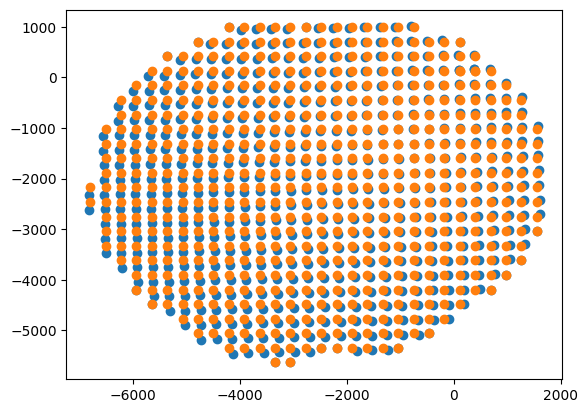

In [30]:
import matplotlib.pylab as plt
plt.scatter(pos_fovs_f[:,0],pos_fovs_f[:,1])
plt.scatter(pos_fovs[:,0],pos_fovs[:,1])

In [31]:
def get_affine(pA,pB):
    # Convert to homogeneous coordinates by adding a column of ones
    import numpy as np
    
    # Assume pA and pB are your input arrays of shape (n_points, 2)
    # For example:
    # pA = np.array([[x1, y1], [x2, y2], ...])
    # pB = np.array([[x1', y1'], [x2', y2'], ...])
    
    # Step 1: Convert points to homogeneous coordinates by adding a column of ones
    pA_hom = np.hstack([pA, np.ones((pA.shape[0], 1))])
    pB_hom = np.hstack([pB, np.ones((pB.shape[0], 1))])
    
    # Step 2: Prepare matrix A using the homogeneous coordinates of pA
    # and matrix B using the points pB (without converting to homogeneous coordinates)
    A = pA_hom
    B = pB
    
    # Step 3: Solve for the best affine transformation matrix X using least squares
    # The resulting matrix X will contain the top two rows of the affine transformation matrix.
    # The last row of the affine transformation matrix is always [0, 0, 1] for 2D transformations.
    X, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    
    # Append the last row [0, 0, 1] to the transformation matrix X to make it 3x3
    #affine_transformation_matrix = np.vstack([X, np.array([[0, 0, 1]])])
    
    #print("Affine transformation matrix:\n", affine_transformation_matrix)
    pBE = np.dot(pA_hom,X)
    return X,pBE
M,pos_fovs_fT = get_affine(pos_fovs[:],pos_fovs_f[:])
diff = pos_fovs_f-pos_fovs
isame  = np.where(np.all(diff==0,axis=-1))[0]
from scipy.spatial import KDTree
good = ~np.all(diff==0,axis=-1)
pos_fovs_ = pos_fovs[good]
dits,inds = KDTree(pos_fovs_).query(pos_fovs[isame],5)
pos_fovs_fT=pos_fovs_f.copy()
pos_fovs_fT[isame] = pos_fovs_fT[isame]+np.mean(diff[good][inds],axis=1)

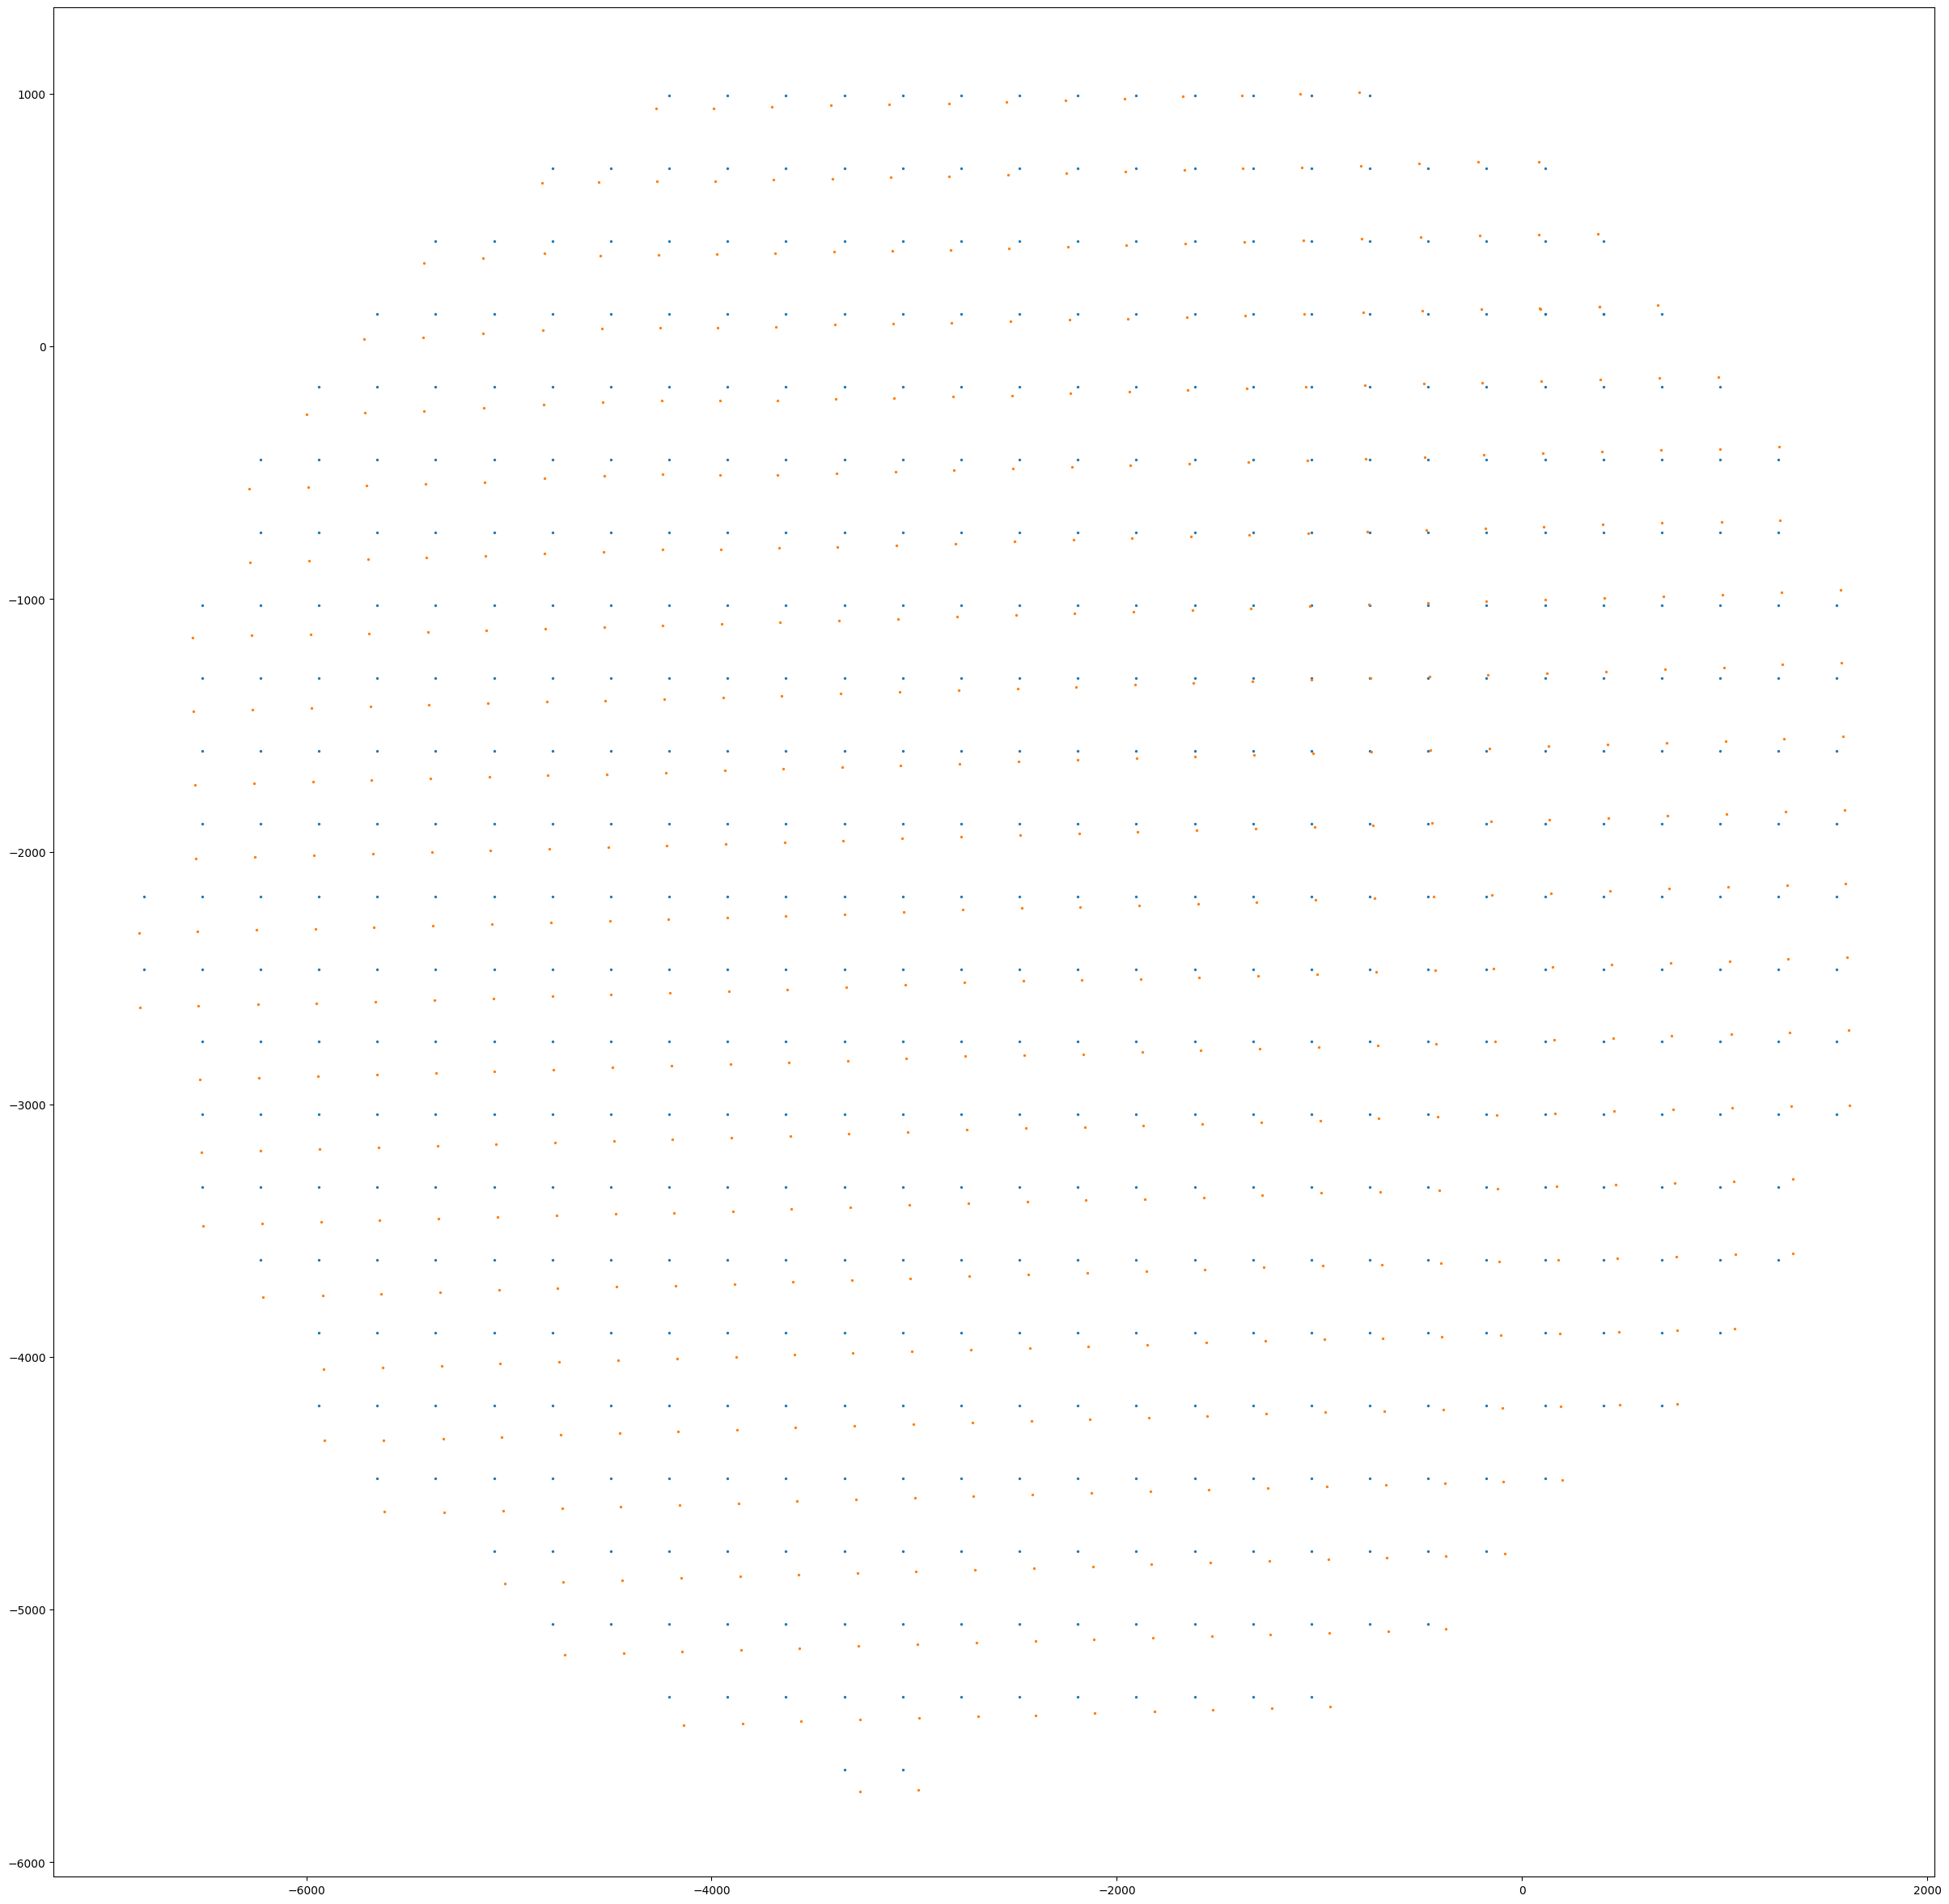

In [32]:
import matplotlib.pylab as plt
plt.figure(figsize=(30,30))
plt.scatter(pos_fovs[:,0],pos_fovs[:,1],s=2)
plt.scatter(pos_fovs_fT[:,0],pos_fovs_fT[:,1],s=2)

In [92]:
import numpy as np
iset=4
for iset in tqdm([0,1,2,3]):
    flsv = rf'U:\MERFISHp\12_04_2025_JenieSample\final_spots\finalspots_s{iset}.npz'
    dic = np.load(flsv)
    Xs=dic['Xs']
    genes=dic['genes']
    pos=dic['pos']
    ifovs=dic['ifovs']
    pos_fovs=dic['pos_fovs']
    
    pos = pos_fovs_fT[ifovs]
    pos = pos[:,[0,0,1]]
    pos[:,0]=0
    pix_size = [0.4,0.108333,0.108333]
    Xsf = Xs[:,:3]*pix_size+pos[:,[0,1,2]]*[1,1,1]
    
    dfov = 2800*pix_size[1]
    pos_middle = pos_fovs_fT+dfov/2
    
    tree = KDTree(pos_middle)
    
    dd,ii = tree.query(Xsf[:,1:],p=np.inf,workers=10)
    
    keepF = ii==ifovs
    
    Xsf = Xsf.astype(np.float32)
    
    Xsf = Xsf[:,[0,1,2,0,0]]
    
    Xsf[:,3:] = Xs[:,3:].astype(np.float32)
    
    ifovs = ifovs.astype(np.int32)
    
    flsv = rf'U:\MERFISHp\12_04_2025_JenieSample\final_spots\finalspots_s{iset}_final.npz'
    np.savez(flsv,Xsf=Xsf[keepF],ifovs=ifovs[keepF],genes=genes[keepF],fls=fls,pos_fovs_fT=pos_fovs_fT,pix_size=pix_size)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:52<00:00, 88.14s/it]


In [41]:
### Generate dapi mosaic

In [76]:
import glob,os
from tqdm import tqdm
import numpy as np
from scipy.signal import fftconvolve
from scipy.spatial import KDTree
def get_pos(fl):
    if fl[-4:]!='.xml': fl = fl.replace('.zarr','')+'.xml'
    for ln in open(fl,'r'):
        if 'stage_position' in ln.lower():
            stage = eval(ln.split('>')[1].split('<')[0])
    return stage
def get_best_translation_points(X,X_ref,resc=5,target=5,return_counts=False):
    im,Xm = get_im_from_Xh(X,resc=resc)
    im_ref,Xm_ref = get_im_from_Xh(X_ref,resc=resc)
    
    
    im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
    #plt.imshow(np.max(im_cor,0))
    tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1+Xm-Xm_ref
    tzxy = tzxy*resc
    Npts=0
    tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc,target=target)
    if return_counts:
        return tzxy,Npts
    return tzxy
def get_Xtzxy(X,X_ref,tzxy0,resc,target=3):
    #print("Check2", tzxy0)
    tzxy = tzxy0
    Npts =0
    for dist_th in np.linspace(resc,target,5):
        #print(np.mean(X))
        #print("Check3", tzxy)
        XT = X-tzxy
        ds,inds = KDTree(X_ref).query(XT)
        keep = ds<dist_th
        X_ref_ = X_ref[inds[keep]]
        X_ = X[keep]
        if len(X_) == 0:
            break
        tzxy = np.mean(X_-X_ref_,axis=0)
        #print(tzxy)
        Npts = np.sum(keep)
    return tzxy,Npts
def get_im_from_Xh(Xh,resc=5,pad=0):
    X = np.round(Xh[:,:3]/resc).astype(int)
    Xm = np.min(X,axis=0)
    XM = np.max(X,axis=0)
    keep = X<=(XM-[0,pad,pad])
    keep &= X>=(Xm+[0,pad,pad])
    keep = np.all(keep,-1)
    X = X[keep]
    if True:
        Xm = np.min(X,axis=0)
        X-=Xm
    else:
        Xm=np.array([0,0,0])
        X = X[np.all(X>=0,axis=-1)]
    
    sz = np.max(X,axis=0)
    imf = np.zeros(sz+1,dtype=np.float32)
    imf[tuple(X.T)]=1
    return imf,Xm

In [77]:
fls = glob.glob(r'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\H1_MER_set1\*.zarr')
pos = [get_pos(fl) for fl in tqdm(fls)]
fovs = np.array([os.path.basename(fl).replace('.zarr','')for fl in fls])
pos=np.array(pos)

In [79]:
pix_size=0.1083333
sz=2800
pos_pix = np.array(pos)[:,::-1]*[1,-1]/pix_size
pos_pix = pos_pix-np.min(pos_pix,axis=0)

In [82]:
tree = KDTree(pos_pix)
pairs = list(tree.query_pairs(1.1*sz))
dic_drift_neigh = {}
for i1,i2 in tqdm(pairs):
    fov1,fov2 = fovs[i1],fovs[i2]
    save_folder = r'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\MERmake_decoding'
    fl1 = rf'{save_folder}\{fov1}--H1_MER_set1--dapiFeatures.npz'
    fl2 = rf'{save_folder}\{fov2}--H1_MER_set1--dapiFeatures.npz'
    X1 = np.load(fl1)['Xh_plus'][:,:3]+pos_pix[i1][[0,0,1]]*[0,1,1]
    X2 = np.load(fl2)['Xh_plus'][:,:3]+pos_pix[i2][[0,0,1]]*[0,1,1]
    if (len(X1)>0) and (len(X2)>0):
        res = KDTree(X1).query_ball_point(X2,150)
        elems = [(ir,r_) for ir,r in enumerate(res) if len(r) for r_ in r]
        if len(elems):
            i2s,i1s = zip(*elems)
            i1s,i2s = np.unique(i1s),np.unique(i2s)
            X1_ = X1[i1s]
            X2_ = X2[i2s]
            tzxy,ncts = get_best_translation_points(X1_,X2_,resc=5,return_counts=True)
            dic_drift_neigh[(i1,i2)]=(tzxy,ncts)
import pickle
fl_save = os.path.dirname(save_folder)+os.sep+'dic_drift_neigh.pkl'
pickle.dump([dic_drift_neigh,fovs,pos,pos_pix],open(fl_save,'wb'))

In [84]:
import pickle
save_folder = r'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\MERmake_decoding'
fl_save = os.path.dirname(save_folder)+os.sep+'dic_drift_neigh.pkl'
dic_drift_neigh,fovs,pos,pos_pix = pickle.load(open(fl_save,'rb'))

In [ ]:
sz=2800
dice = {}
for i1,i2 in dic_drift_neigh:
    key = tuple(np.round((pos_pix[i1]-pos_pix[i2])/sz).astype(int))
    #print(key,np.round(dic_drift_neigh[(i1,i2)][0]))
    tzxy = dic_drift_neigh[(i1,i2)][0]
    if dic_drift_neigh[(i1,i2)][-1]>0: 
        dice[key]=dice.get(key,[])+[tzxy]
for key in dice:
    x = np.array(dice[key])
    d = np.linalg.norm(x,axis=-1)
    dice[key]=np.median(x[d<100],axis=0)
dic_drift_neigh_expected = {}
for i1,i2 in dic_drift_neigh:
    key = tuple(np.round((pos_pix[i1]-pos_pix[i2])/sz).astype(int))
    dic_drift_neigh_expected[(i1,i2)]=dice[key]

In [ ]:
dic_drift_neigh_f = {}
count = 0
for key in dic_drift_neigh:
    ncounts = dic_drift_neigh[key][-1]
    dif = dic_drift_neigh[key][0]-dic_drift_neigh_expected[key]
    if (np.max(np.abs(dif))>50)|(ncounts<10):
        count+=1
        #dic_drift_neigh_f[key]=np.array([np.nan]*3)
        i1,i2=key
        key_ = tuple(np.round((pos_pix[i1]-pos_pix[i2])/sz).astype(int))
        dic_drift_neigh_f[key]=dice[key_]
    else:
        dic_drift_neigh_f[key]=dic_drift_neigh[key][0]
#dic_drift_neigh_f

In [ ]:
dic_drift_neigh_fC = {key:np.array(dic_drift_neigh_f[key]) for key in dic_drift_neigh_f}
dic_modif = {}
dic_to_modif = {}
for ielem in np.arange(len(pos_pix)):
    dic_to_modif[ielem]=[(key,1) if key[0]==ielem else (key,-1) for key in dic_drift_neigh_f if ielem in key]
ielems = np.unique(list(dic_drift_neigh_fC.keys()))

In [ ]:
for it in tqdm(np.arange(100)):
    for ielem in ielems:
        dic_modif[ielem]=dic_modif.get(ielem,np.array([0,0,0]))+np.nanmean([dic_drift_neigh_fC[key]*factor for key,factor in dic_to_modif[ielem]],axis=0)
    for key in dic_drift_neigh_fC:
        i1,i2 = key
        dic_drift_neigh_fC[(i1,i2)]=dic_drift_neigh_fC[(i1,i2)]-dic_modif[i1]+dic_modif[i2]
    print(np.nanmedian(np.linalg.norm(np.array(list(dic_drift_neigh_fC.values())),axis=-1)))

In [ ]:
pos_pixf = [([0]+list(pos_pix[ielem]))-dic_modif.get(ielem,np.array([np.nan]*3)) for ielem in np.arange(len(pos_pix))]
pos_pixf = np.array(pos_pixf)
isgood = ~np.isnan(pos_pixf[:,0])
pos_pixf_ = pos_pixf[isgood]

dd,ii = KDTree(pos_pix[isgood]).query(pos_pix[~isgood],4)
xff = pos_pix[~isgood]+np.mean(pos_pix[isgood][ii]-pos_pixf[isgood][ii][...,-2:],axis=1)
xff = xff[:,[0,0,1]]
xff[:,0]=0
pos_pixf[~isgood] = xff
#V = napari.view_points(pos_pixf_[:,-2:],size=10,face_color='g',border_width=0)
#V.add_points(pos_pix,size=10,face_color='r',border_width=0)
pos_pixf = pos_pixf-np.min(pos_pixf,axis=0)*[0,1,1]
pos_pixf = np.round(pos_pixf).astype(int)
pos_pixff = pos_pixf[:,:]//[1,3,3]

In [1]:
import sys
#sys.path.append(r'X:\Lab\Raw_custom_MERFISH_Imaging_data\20250720_hBG_3924_CaPuNAc\analysis_notebooks')
from ioMicro import read_im

In [6]:
from ioMicro import read_im
import cv2
import numpy as np
immed = np.load(r'U:\MERFISHp\12_04_2025_JenieSample\Mammoth_med_col_raw3.npz')['im']
immed = cv2.blur(immed,(20,20))
immed=immed/np.median(immed)
import napari
napari.view_image(immed);

In [7]:
dic = np.load(r'U:\MERFISHp\12_04_2025_JenieSample\final_spots\finalspots_s0_final.npz')
pos_fovs_fT = dic['pos_fovs_fT']
fls = dic['fls']
pix_size = dic['pix_size']

Cannot find steve


In [22]:
# ifov = 20
# fl = fls[ifov]
# fov = fl.split('decodedNew_')[-1].split('--')[0]
# fl_raw = rf'U:\MERFISHp\12_04_2025_JenieSample\H1_MER_set1\{fov}'
# fr = 20
# imf = read_im(fl_raw)[-1]
# im = imf[fr]/immed
# #napari.view_image(im)

In [29]:
# dists = np.linalg.norm(pos_fovs_fT-pos_fovs_fT[ifov],axis=-1)
# ifovsN = np.argsort(dists)[:9]

In [8]:
N = int(40*0.4/1.5)
zframes = np.round(np.linspace(0,40,N)).astype(int)[:-1]
zframes,len(zframes)

(array([ 0,  4,  9, 13, 18, 22, 27, 31, 36]), 9)

In [13]:
#from scipy.spatial import KDTree
#KDTree(pos_fovs_fT).query_ball_point(pos_fovs_fT,50)

In [16]:
for iframe in np.arange(len(zframes)):
    fr = zframes[iframe]
    ifovsN = np.arange(len(pos_fovs_fT))[:-2]
    pos_fovs_ = pos_fovs_fT[ifovsN]
    resc = 3
    szfov=2800
    vmax=50000
    pos_pix = np.round(pos_fovs_/pix_size[1:]/resc).astype(int)
    pos_pix = pos_pix-np.min(pos_pix,axis=0)
    szfull = np.max(pos_pix,axis=0)+int(np.round(szfov/3))+1
    imf = np.zeros(szfull,dtype=np.uint8)
    from scipy.spatial import KDTree
    from tqdm import tqdm
    for (ix,iy),ifov in zip(tqdm(pos_pix),ifovsN):
        fl = fls[ifov]
        fov = fl.split('decodedNew_')[-1].split('--')[0]
        fl_raw = rf'U:\MERFISHp\12_04_2025_JenieSample\H1_MER_set1\{fov}'
        
        imT = read_im(fl_raw)[-1]
        im = imT[fr]/immed.T
        im = np.array(im[::resc,::resc])
        sx,sy = im.shape
        im_prev = imf[ix:ix+sx,iy:iy+sy].astype(np.float32)
        #imf[ix:ix+sx,iy:iy+sy]=im
        im_ = im/vmax*255
        if np.sum(im_prev>0):
            Xasigned = np.array(np.where(im_prev>0)).T
            Xunasigned = np.array(np.where(im_prev==0)).T
            dda,ii = KDTree(Xunasigned).query(Xasigned,workers=10)
            #ddu,ii = KDTree(Xasigned).query(Xunasigned)
            im_prev_ = np.zeros_like(im_prev,dtype=np.float32)
            im_prev_[tuple(Xasigned.T)]=dda/np.max(dda)
            
            imTT = (im_prev*im_prev_+im_*(1-im_prev_))
            imf[ix:ix+sx,iy:iy+sy]=np.clip(imTT,1,255).astype(np.uint8)
        else:
            imf[ix:ix+sx,iy:iy+sy]=np.clip(im_,1,255).astype(np.uint8)
    
    import tifffile as tiff
    save_folder_mosaics = r'U:\MERFISHp\12_04_2025_JenieSample\final_spots'
    tiff.imwrite(
        rf"{save_folder_mosaics}\dapi_z{iframe+1}.tif",
        imf,
        bigtiff=True,
        tile=(1024, 1024),
        compression="zstd",  # needs imagecodecs; else use "deflate" or "lzma"/"lzw"
        photometric="minisblack"
    )

100%|████████████████████████████████████████████████████████████████████████████████| 561/561 [06:18<00:00,  1.48it/s]


In [17]:
imf = tiff.imread(r'U:\MERFISHp\12_04_2025_JenieSample\final_spots\dapi_z4.tif')

In [18]:
import napari
napari.view_image(imf)

Viewer(camera=Camera(center=(0.0, np.float64(13450.0), np.float64(10815.0)), zoom=np.float64(0.026307151772918497), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(26900.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(21630.0), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(13450.0), np.float64(10815.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'imf' at 0x1e2328dd1f0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[<f

Cannot find steve


In [ ]:
os.makedirs(r"Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB",exist_ok=True)
zframes = np.round(np.linspace(3,22,7)).astype(int)
for iframe in np.arange(len(zframes)):
    szf = np.max(pos_pixff[:,-2:],axis=0)+sz
    imf = np.zeros(szf,dtype=np.uint8)
    for ifov in tqdm(np.arange(len(pos_pixff))):
        
        zframe = zframes[iframe]
        fov =  fovs[ifov]
        z,x,y = pos_pixff[ifov]
        #x,y = pos_pix[ifov].astype(int)//3
        im = read_im(rf'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\H1_MER_set1\{fov}')[-1]
        frame = zframe+z
        if frame<0: frame=0
        if frame>=len(im): frame = len(im)-1
        imT = np.clip(1+np.array(im[frame])/immed/255,0,255).astype(np.uint8)[::3,::3]
        sx,sy = imT.shape
    
        im_prev = imf[x:x+sx,y:y+sy]
        if np.sum(im_prev>0):
            Xasigned = np.array(np.where(im_prev>0)).T
            Xunasigned = np.array(np.where(im_prev==0)).T
            dda,ii = KDTree(Xunasigned).query(Xasigned)
            #ddu,ii = KDTree(Xasigned).query(Xunasigned)
            im_prev_ = np.zeros_like(im_prev,dtype=np.float32)
            im_prev_[tuple(Xasigned.T)]=dda/np.max(dda)
            
            imTT = (im_prev*im_prev_+imT*(1-im_prev_)).astype(np.uint8)
            imf[x:x+sx,y:y+sy]=imTT#np.max([imT,imf[x:x+sx,y:y+sy]],axis=0)
        else:
            imf[x:x+sx,y:y+sy]=imT
    #imQ = tiff.imread(rf"Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB\dapi_z{iframe+1}.tif")
    import tifffile as tiff
    tiff.imwrite(
        rf"Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB\dapi_z{iframe+1}.tif",
        imf,
        bigtiff=True,
        tile=(1024, 1024),
        compression="zstd",  # needs imagecodecs; else use "deflate" or "lzma"/"lzw"
        photometric="minisblack"
    )

In [ ]:
fl = r'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB\detected_transcripts.csv'
fid = open(fl,'w')
header = ['global_z','global_x','global_y','genes','score','xfov','yfov']
fid.write(','.join(header)+'\n')
for ie in tqdm(np.arange(len(z))):
    z_,x_,y_,gene_,score_,xfov_,yfov_ = z[ie],x[ie],y[ie],genes[ie],score[ie],xfov[ie],yfov[ie]
    txt = ','.join(map(str,[z_,x_,y_,gene_,score_,xfov_,yfov_]))+'\n'
    fid.write(txt)
fid.close()

In [ ]:
np.savez_compressed(r'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB\detected_transcripts.npz',
                    global_z=z,global_x=x.astype(np.float32),global_y=y.astype(np.float32),
                    genes=genes,score=score,xfov=xfov,yfov=yfov)

In [ ]:
npfl = np.load(r'Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB\detected_transcripts.npz')
x = npfl['global_x']
y = npfl['global_y']
genes = npfl['genes']

import tifffile
imdapi = tifffile.imread(rf"Z:\Lab\Raw_custom_MERFISH_Imaging_data\20250430_XXhBG_2724\mosaicsBB\dapi_z3.tif")


V = napari.Viewer()
V.add_image([imdapi,imdapi[::2,::2],imdapi[::4,::4]])
keep = genes=='DRD2'
X = np.array([x[keep],y[keep]]).T
V.add_points(X,border_width=0,face_color='r',name='DRD2')
keep = genes=='DRD1'
X = np.array([x[keep],y[keep]]).T
V.add_points(X,border_width=0,face_color='g',name='DRD1')

In [78]:
import napari
V = napari.Viewer()
cols = ['r','g','y','c','m','w','orange','teal']


for ign,gene in enumerate(['Gad2',  'Chat','Mog','Rorb']):
    is_gene = genes==gene
    X = Xsf[is_gene&keepF]
    col = cols[ign%len(cols)]   
    V.add_points(X[:,1:],border_width=0,face_color=col,size=1,name=gene)

In [66]:
vals,cts = np.unique(np.round(np.abs(np.diff(pos_fovs_fT,axis=0))),return_counts=True)
vals[vals>100][np.argmax(cts[vals>100])]

np.float64(290.0)

In [42]:
neigh = neighs[79]
import napari
V = napari.Viewer()
cols = ['r','g','y','c','m','w','orange','teal']

for ifv,ifovn in enumerate(neigh):
    keep = ifovs==ifovn
    X2d = Xsf[keep][:,1:]
    V.add_points(X2d,border_width=0,size=0.2,face_color=cols[ifv%len(cols)])

Cannot find steve
